In [35]:
import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization,UpSampling2D,Concatenate
from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

from tqdm import tqdm_notebook

import warnings

import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
img_size_ori = 101
img_size_target = 128

im_width = 101
im_height = 101
im_chan = 1
basicpath = '../input/'
path_train = basicpath + 'train/'
path_test = basicpath + 'test/'

path_train_images = path_train + 'images/'
path_train_masks = path_train + 'masks/'
path_test_images = path_test + 'images/'

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

In [12]:
train_df = pd.read_csv("./input/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("./input/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [13]:
train_df["images"] = [np.array(load_img("./input/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]
train_df["masks"] = [np.array(load_img("./input/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

### Calculating the salt coverage and salt coverage classes
Counting the number of salt pixels in the masks and dividing them by the image size. Also create 11 coverage classes, -0.1 having no salt at all to 1.0 being salt only. Plotting the distribution of coverages and coverage classes, and the class against the raw coverage.

In [14]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [15]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

Text(0.5,0,'Coverage class')

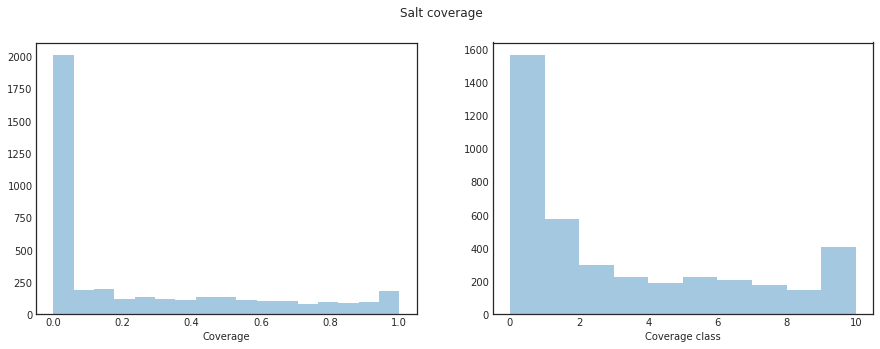

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

### Plotting the depth distributions
Separatelty plotting the depth distributions for the training and the testing data

Text(0.5,1,'Depth distribution')

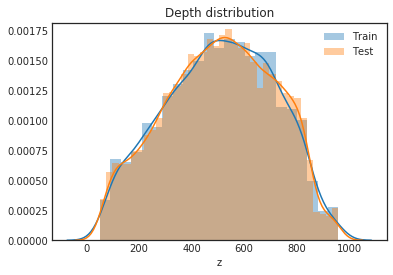

In [18]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

Examples

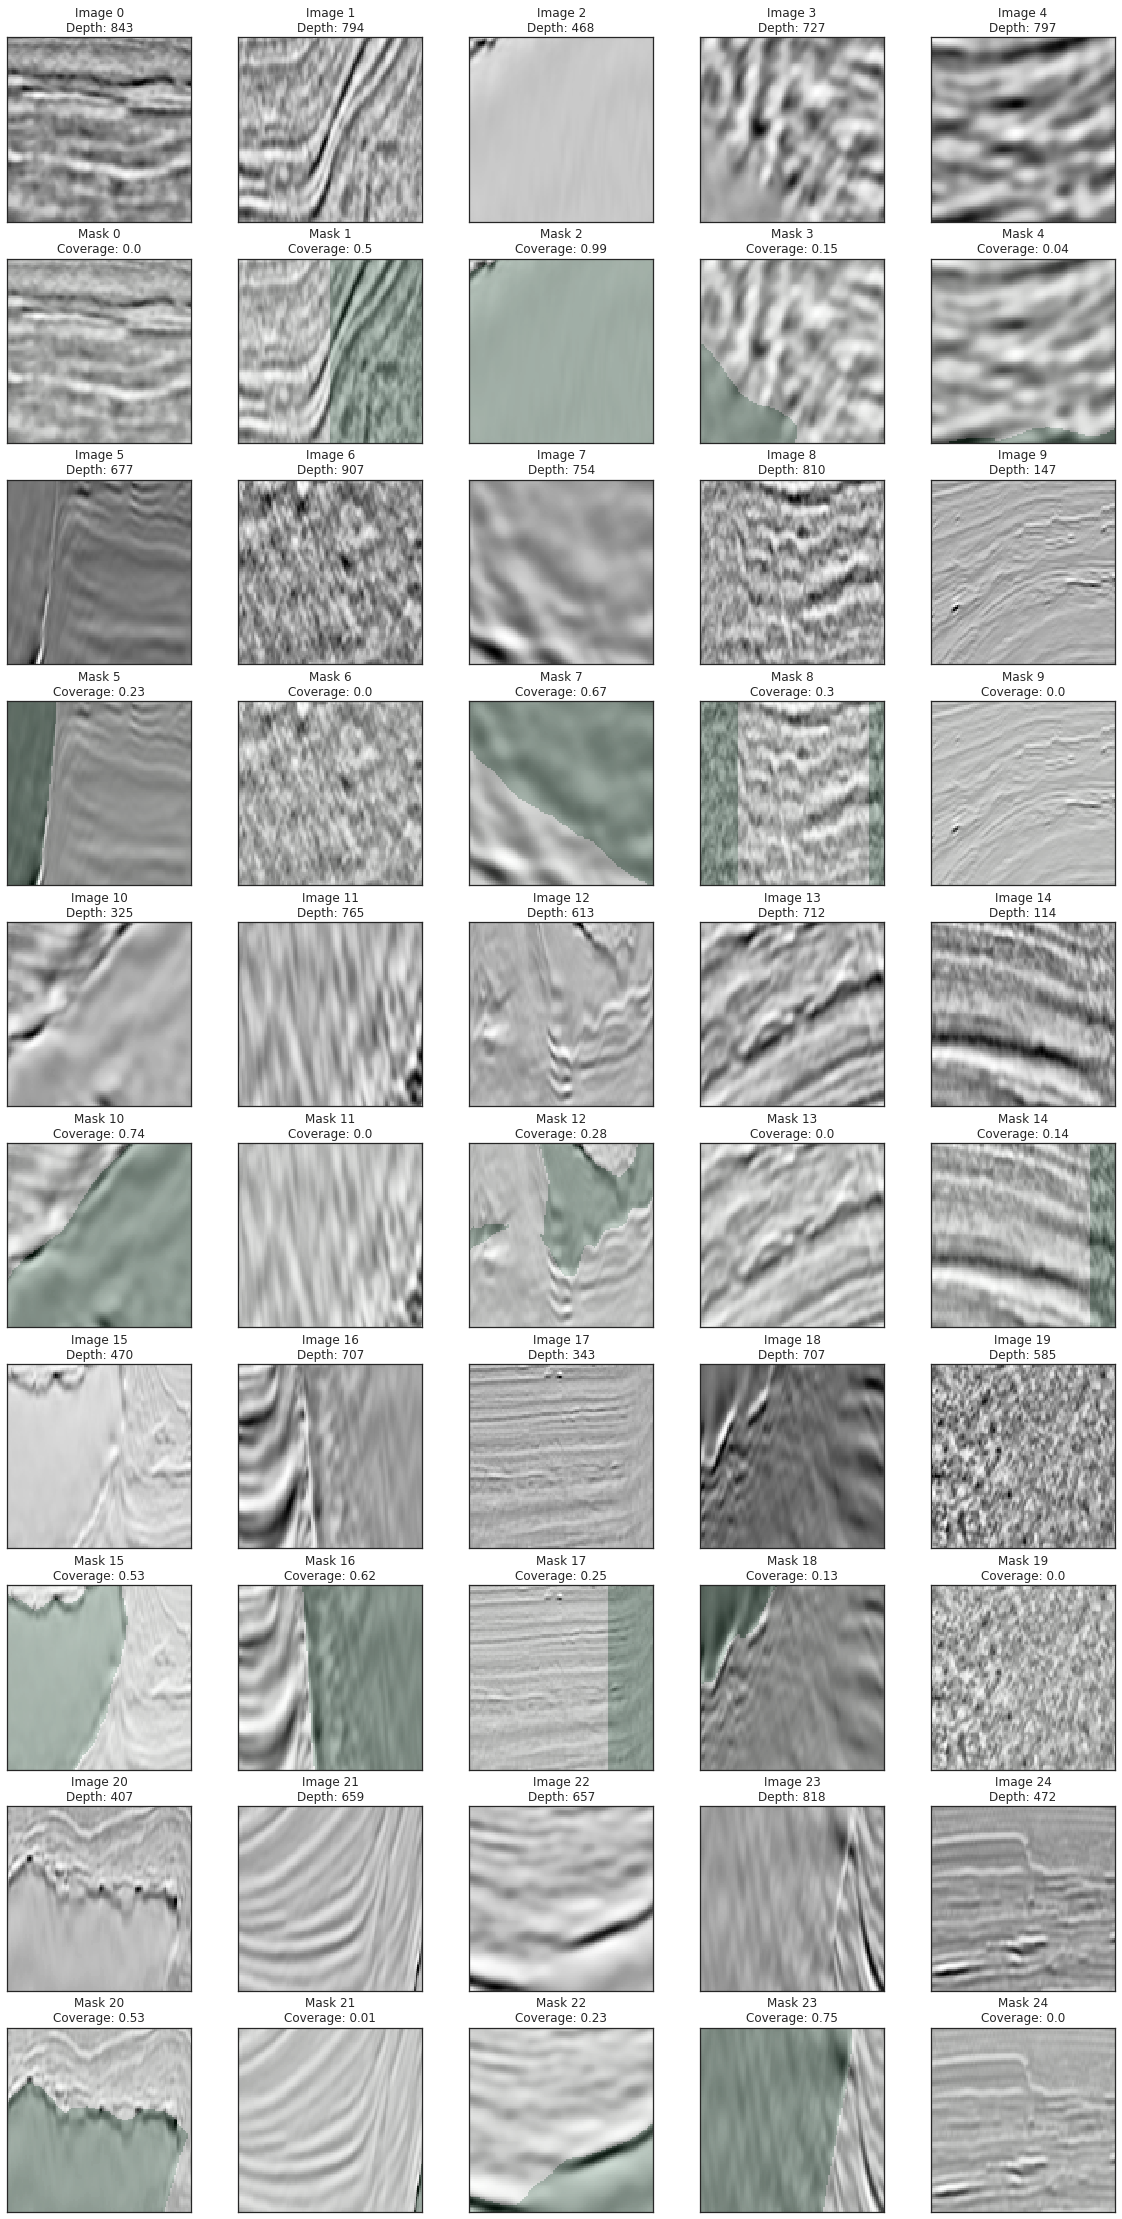

In [21]:
max_images = 25
grid_width = 5
grid_height = int(max_images / grid_width)*2
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*4, grid_height*4))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax_image = axs[int(i / grid_width)*2, i % grid_width]
    ax_image.imshow(img, cmap="Greys")
    ax_image.set_title("Image {0}\nDepth: {1}".format(i, train_df.loc[idx].z))
    ax_image.set_yticklabels([])
    ax_image.set_xticklabels([])
    ax_mask = axs[int(i / grid_width)*2+1, i % grid_width]
    ax_mask.imshow(img, cmap="Greys")
    ax_mask.imshow(mask, alpha=0.2, cmap="Greens")
    ax_mask.set_title("Mask {0}\nCoverage: {1}".format(i,  round(train_df.loc[idx].coverage, 2)))
    ax_mask.set_yticklabels([])
    ax_mask.set_xticklabels([])

In [22]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

In [26]:
from sklearn.model_selection import KFold
import os
DATA_ROOT = './input/'

n_fold = 5
depths = pd.read_csv(os.path.join(DATA_ROOT, 'depths.csv'))
depths.sort_values('z', inplace=True)
depths.drop('z', axis=1, inplace=True)
depths['fold'] = (list(range(n_fold))*depths.shape[0])[:depths.shape[0]]
depths.to_csv(os.path.join(DATA_ROOT, 'folds.csv'), index=False)

In [28]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    ucov1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

In [29]:
def conv_block(m, dim, acti, bn, res, do=0):
    n = Conv2D(dim, 3, activation=acti, padding='same')(m)
    n = BatchNormalization()(n) if bn else n
    n = Dropout(do)(n) if do else n
    n = Conv2D(dim, 3, activation=acti, padding='same')(n)
    n = BatchNormalization()(n) if bn else n
    return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
    if depth > 0:
        n = conv_block(m, dim, acti, bn, res)
        m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
        m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
        if up:
            m = UpSampling2D()(m)
            m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        else:
            m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
        n = Concatenate()([n, m])
        m = conv_block(n, dim, acti, bn, res)
    else:
        m = conv_block(m, dim, acti, bn, res, do)
    return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
         dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
    i = Input(shape=img_shape)
    o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
    o = Conv2D(out_ch, 1, activation='sigmoid')(o)
    return Model(inputs=i, outputs=o)

In [36]:
#model = Model(input_layer, output_layer)
model = UNet((img_size_target,img_size_target,1),start_ch=16,depth=5,batchnorm=True)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [37]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 128, 128, 16) 160         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_22[0][0]                  
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 128, 128, 16) 2320        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

Text(0.5,0.98,'Top row: original images, bottom row: augmented images')

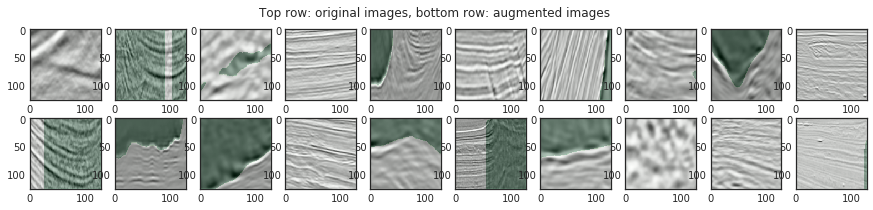

In [38]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")

In [39]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000005, verbose=1)

epochs = 200
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Train on 3200 samples, validate on 800 samples
Epoch 1/200
3200/3200 [==============================] - 19s 6ms/step - loss: 0.5107 - acc: 0.7937 - val_loss: 0.6434 - val_acc: 0.8305

Epoch 00001: val_loss improved from inf to 0.64345, saving model to ./keras.model
Epoch 2/200
3200/3200 [==============================] - 13s 4ms/step - loss: 0.3478 - acc: 0.8749 - val_loss: 0.5839 - val_acc: 0.8489

Epoch 00002: val_loss improved from 0.64345 to 0.58395, saving model to ./keras.model
Epoch 3/200
3200/3200 [==============================] - 13s 4ms/step - loss: 0.3171 - acc: 0.8734 - val_loss: 0.5601 - val_acc: 0.8426

Epoch 00003: val_loss improved from 0.58395 to 0.56011, saving model to ./keras.model
Epoch 4/200
3200/3200 [==============================] - 13s 4ms/step - loss: 0.2836 - acc: 0.8868 - val_loss: 0.2778 - val_acc: 0.8953

Epoch 00004: val_loss improved from 0.56011 to 0.27782, saving model to ./keras.model
Epoch 5/200
3200/3200 [==============================] - 12s 4ms/

3200/3200 [==============================] - 12s 4ms/step - loss: 0.0585 - acc: 0.9682 - val_loss: 0.1624 - val_acc: 0.9394

Epoch 00041: val_loss did not improve from 0.14664
Epoch 42/200
3200/3200 [==============================] - 12s 4ms/step - loss: 0.0580 - acc: 0.9686 - val_loss: 0.1619 - val_acc: 0.9400

Epoch 00042: val_loss did not improve from 0.14664
Epoch 43/200
3200/3200 [==============================] - 12s 4ms/step - loss: 0.0582 - acc: 0.9683 - val_loss: 0.1616 - val_acc: 0.9402

Epoch 00043: val_loss did not improve from 0.14664

Epoch 00043: ReduceLROnPlateau reducing learning rate to 5e-06.
Epoch 00043: early stopping


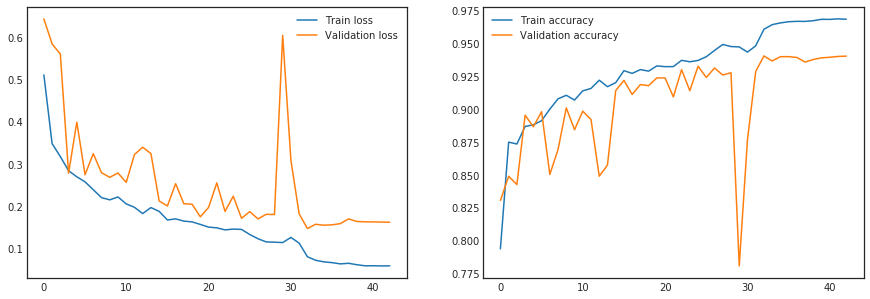

In [40]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
ax_acc.legend()

In [42]:
#model = load_model("./keras.model")

### Score
Score the model and do a threshold optimization by the best IoU.

In [44]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [46]:
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
mask_valid = np.array([downsample(x) for x in y_valid])

In [47]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(mask_valid, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

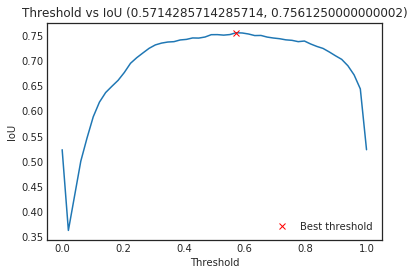

In [48]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

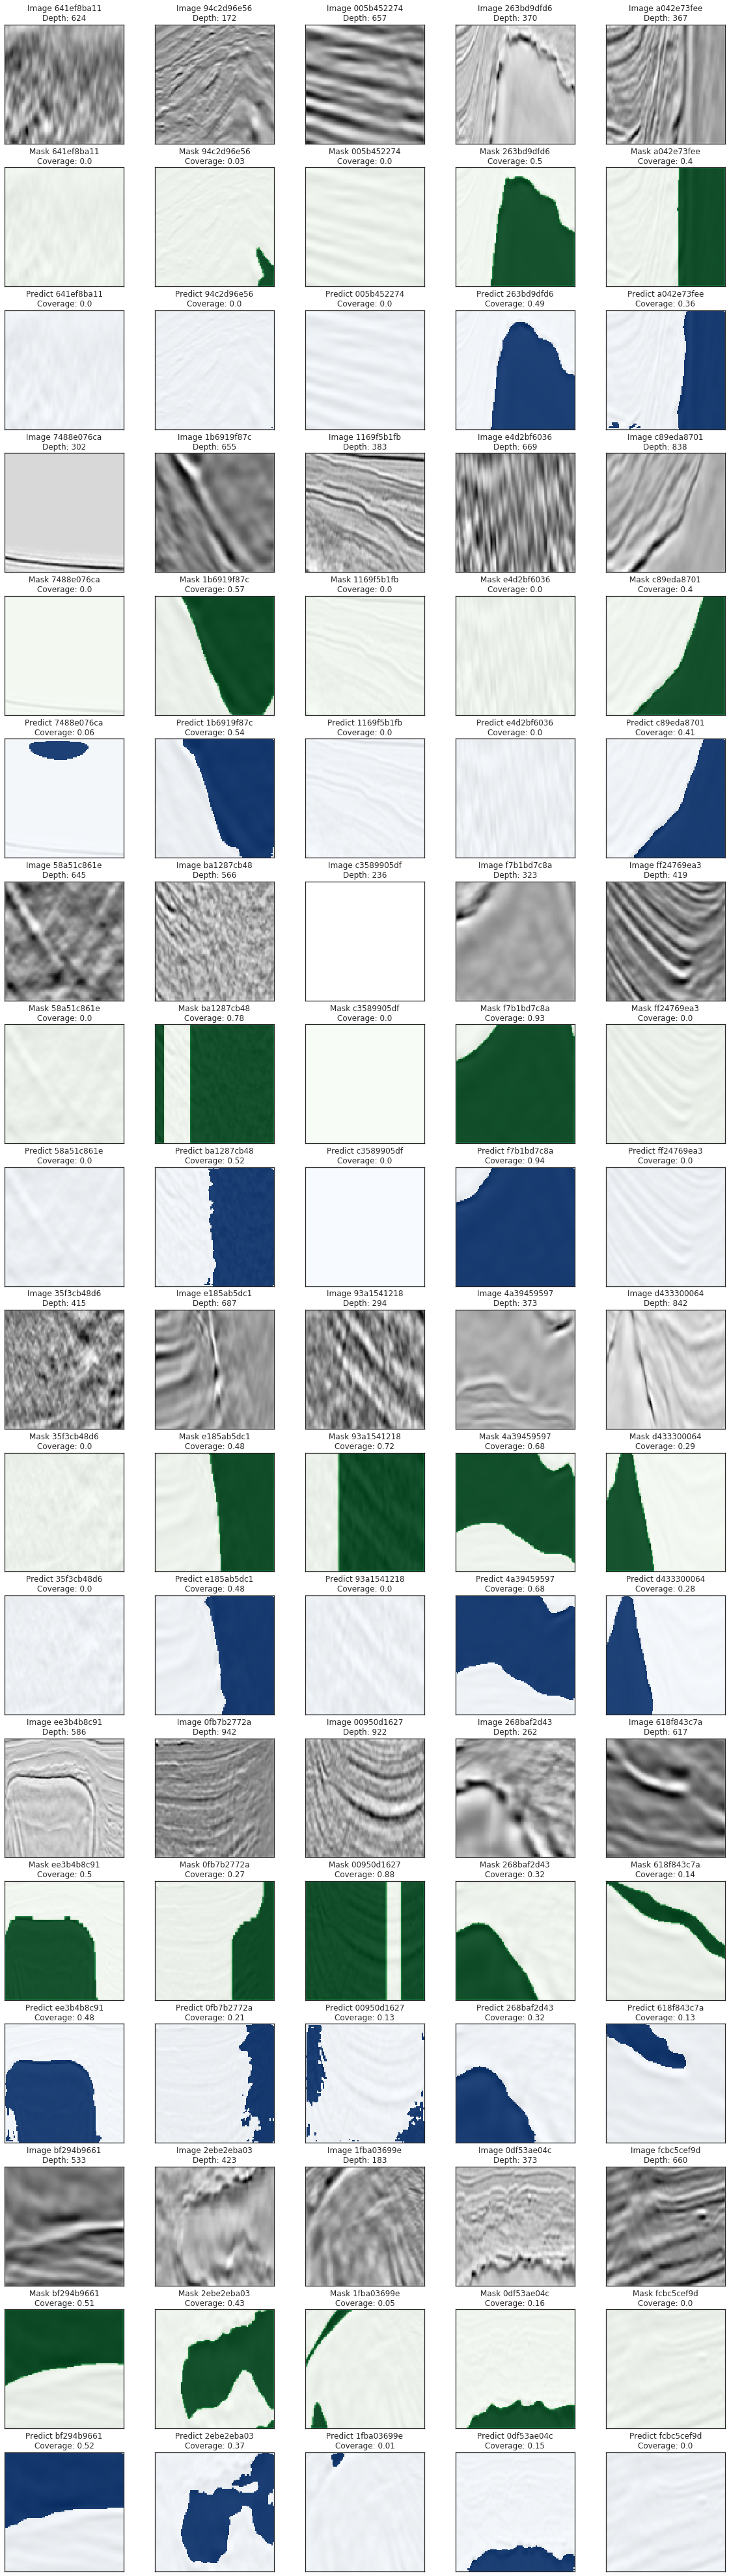

In [49]:
max_images = 30
grid_width = 5
grid_height = int(max_images / grid_width)*3
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*4, grid_height*4))
for i, idx in enumerate(ids_valid[:max_images]):
    #print(idx)
    img = downsample(np.squeeze(x_valid[i]))
    mask = np.squeeze(mask_valid[i])
    pred = np.squeeze(preds_valid[i]>threshold_best)
    ax_image = axs[int(i / grid_width)*3, i % grid_width]
    ax_image.imshow(img, cmap="Greys")
    ax_image.set_title("Image {0}\nDepth: {1}".format(idx, train_df.loc[idx].z))
    ax_image.set_yticklabels([])
    ax_image.set_xticklabels([])
    ax_mask = axs[int(i / grid_width)*3+1, i % grid_width]
    ax_mask.imshow(img, cmap="Greys")
    ax_mask.imshow(mask, alpha=0.9, cmap="Greens")
    ax_mask.set_title("Mask {0}\nCoverage: {1}".format(idx,  round(train_df.loc[idx].coverage, 2)))
    ax_mask.set_yticklabels([])
    ax_mask.set_xticklabels([])
    ax_pred = axs[int(i / grid_width)*3+2, i % grid_width]
    ax_pred.imshow(img, cmap="Greys")
    ax_pred.imshow(pred, alpha=0.9, cmap="Blues")
    coverage_pred = np.sum(pred) / pow(img_size_ori, 2)
    ax_pred.set_title("Predict {0}\nCoverage: {1}".format(idx,  round(coverage_pred, 2)))
    ax_pred.set_yticklabels([])
    ax_pred.set_xticklabels([])

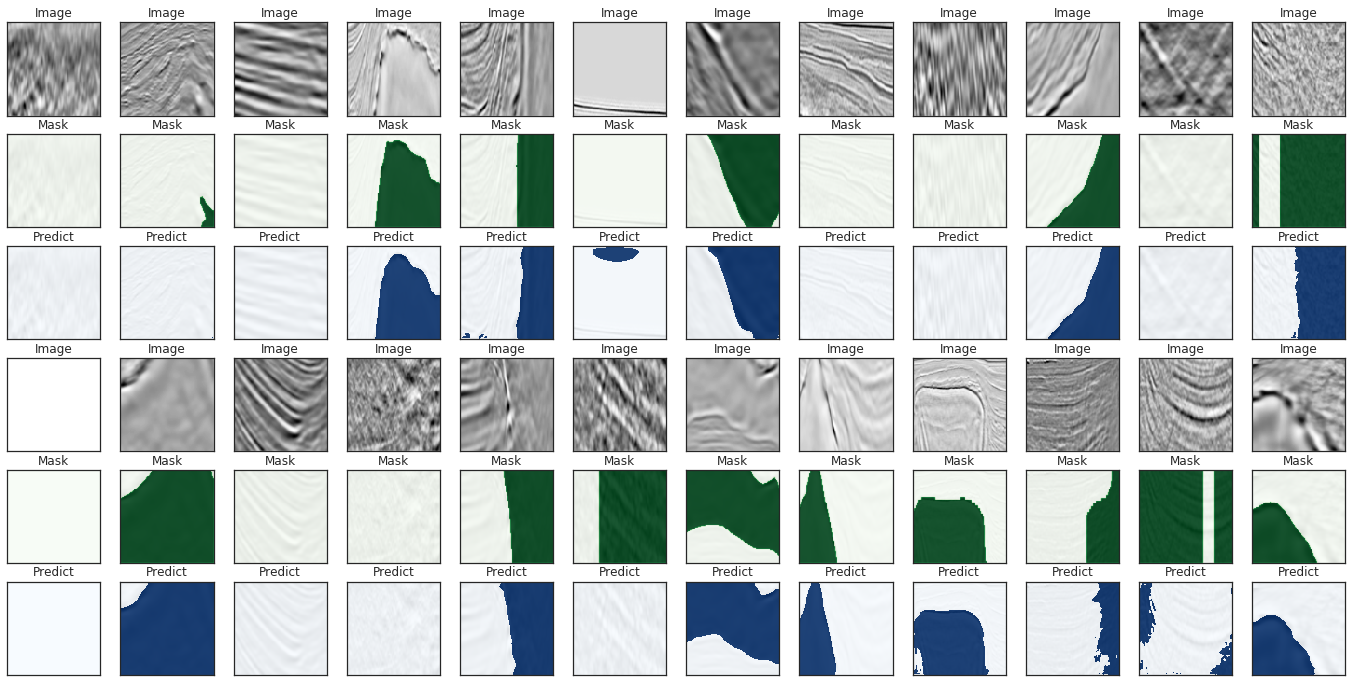

In [50]:
# plot small charts
max_images = 24
grid_width = 12
grid_height = int(max_images / grid_width)*3
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*2, grid_height*2))
for i, idx in enumerate(ids_valid[:max_images]):
    #print(idx)
    img = downsample(np.squeeze(x_valid[i]))
    mask = np.squeeze(mask_valid[i])
    pred = np.squeeze(preds_valid[i]>threshold_best)
    ax_image = axs[int(i / grid_width)*3, i % grid_width]
    ax_image.imshow(img, cmap="Greys")
    ax_image.set_title("Image")
    ax_image.set_yticklabels([])
    ax_image.set_xticklabels([])
    ax_mask = axs[int(i / grid_width)*3+1, i % grid_width]
    ax_mask.imshow(img, cmap="Greys")
    ax_mask.imshow(mask, alpha=0.9, cmap="Greens")
    ax_mask.set_title("Mask")
    ax_mask.set_yticklabels([])
    ax_mask.set_xticklabels([])
    ax_pred = axs[int(i / grid_width)*3+2, i % grid_width]
    ax_pred.imshow(img, cmap="Greys")
    ax_pred.imshow(pred, alpha=0.9, cmap="Blues")
    coverage_pred = np.sum(pred) / pow(img_size_ori, 2)
    ax_pred.set_title("Predict")
    ax_pred.set_yticklabels([])
    ax_pred.set_xticklabels([])

In [52]:
## predict

# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [54]:
x_test = np.array([upsample(np.array(load_img("./input/test/images/{}.png".format(idx), grayscale=True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

In [55]:
preds_test = model.predict(x_test)

In [56]:
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [58]:
import datetime

sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
#sub.to_csv('submission.csv')
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
print('Submission output to: sub-{}.csv'.format(timestamp))
sub.to_csv("sub-{}.csv".format(timestamp))

Submission output to: sub-20180902-1327.csv
